In [ ]:
%%capture
!pip install datasets transformers evaluate sentencepiece accelerate
!pip install -U openai

In [2]:
import numpy as np
import pandas as pd

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import torch
import evaluate

In [3]:
train_df = pd.read_csv("/kaggle/input/personality/data/personality_train.csv")
print(train_df.shape)
train_df.sample(3)

(7129, 10)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,text,EI,SN,TF,JP,O,C,E,A,N
6326,"as I sit here to begin writing, I was stood up...",NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,1.0
6469,"Ok, so I guess I am just going to start writin...",NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,1.0
4342,'10/10 kinda reminds me of the end by the door...,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN


In [4]:
val_df = pd.read_csv("/kaggle/input/personality/data/personality_val.csv")
print(val_df.shape)
val_df.sample(3)

(1783, 10)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,text,EI,SN,TF,JP,O,C,E,A,N
682,'Still on The Witcher series. I just started T...,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
1,I look like a vegan SJW with brightly colored ...,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
1185,'I'm bouncing in and out of this thread as my ...,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [5]:
test_df = pd.read_csv("/kaggle/input/personality/data/personality_test.csv")
print(test_df.shape)
test_df.sample(3)

(2229, 10)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,text,EI,SN,TF,JP,O,C,E,A,N
1897,I have twenty minutes to write. It feels weird...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0
2052,I actually have free time for once in my life!...,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,1.0
1788,I'm sitting all stressed out. For the first ti...,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0


In [6]:
# Filter only MBTI classes

filter_cols = ["text", "EI", "SN", "TF", "JP"]
train_df = train_df[filter_cols].dropna()
val_df = val_df[filter_cols].dropna()
test_df = test_df[filter_cols].dropna()

train_df.shape, val_df.shape, test_df.shape

((5551, 5), (1388, 5), (1735, 5))

In [7]:
classes = ["EI", "SN", "TF", "JP"]
train_df['labels'] = train_df[classes].apply(lambda row: ','.join([trait for trait in classes if row[trait] == 1]).strip(), axis=1)
val_df['labels'] = val_df[classes].apply(lambda row: ','.join([trait for trait in classes if row[trait] == 1]).strip(), axis=1)
test_df['labels'] = test_df[classes].apply(lambda row: ','.join([trait for trait in classes if row[trait] == 1]).strip(), axis=1)

<Axes: xlabel='MBTI Types', ylabel='pcnt of positives'>

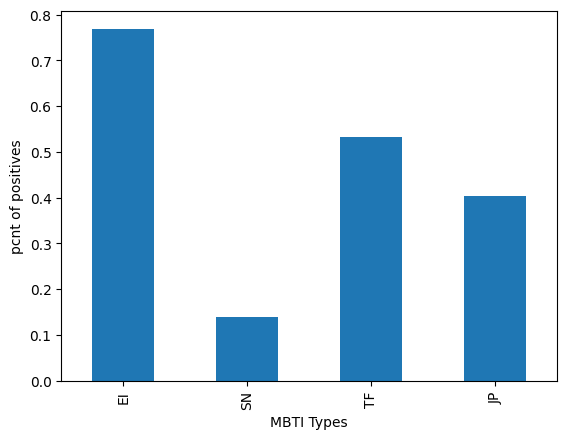

In [60]:
(train_df[classes].sum()/len(train_df)).plot(kind="bar", xlabel='MBTI Types', ylabel="pcnt of positives")

In [8]:
train_ds = Dataset.from_pandas(train_df, preserve_index=False)
val_ds = Dataset.from_pandas(val_df, preserve_index=False)
test_ds = Dataset.from_pandas(test_df, preserve_index=False)
train_ds

Dataset({
    features: ['text', 'EI', 'SN', 'TF', 'JP', 'labels'],
    num_rows: 5551
})

In [9]:

class2id = {class_:id for id, class_ in enumerate(classes)}
id2class = {id:class_ for class_, id in class2id.items()}
class2id, id2class

({'EI': 0, 'SN': 1, 'TF': 2, 'JP': 3}, {0: 'EI', 1: 'SN', 2: 'TF', 3: 'JP'})

In [41]:
model_path = "google-bert/bert-base-uncased"

model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    num_labels=len(classes),
    id2label=id2class,
    label2id=class2id,
    problem_type="multi_label_classification",
    torch_dtype=torch.bfloat16,       # Enables bf16
    device_map="cuda"                 # Automatically places model on CUDA if available
)


tokenizer = AutoTokenizer.from_pretrained(model_path)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [42]:
def preprocess_function(example):
   all_labels = example['labels'].split(',')
   labels = [0. for i in range(len(classes))]
   for label in all_labels:
       if not label: break
       label_id = class2id[label]
       labels[label_id] = 1.
  
   example = tokenizer(example['text'], truncation=True, max_length=256, padding="max_length")
   example['labels'] = labels
   return example

tokenized_train_dataset = train_ds.map(preprocess_function)
tokenized_val_dataset = val_ds.map(preprocess_function)
tokenized_test_dataset = test_ds.map(preprocess_function)

Map:   0%|          | 0/5551 [00:00<?, ? examples/s]

Map:   0%|          | 0/1388 [00:00<?, ? examples/s]

Map:   0%|          | 0/1735 [00:00<?, ? examples/s]

In [43]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [44]:
from sklearn.metrics import f1_score, precision_score, recall_score

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = sigmoid(predictions)
    preds_bin = (predictions > 0.5).astype(int)

    return {
        "f1_macro": f1_score(labels, preds_bin, average="macro"),
        "f1_samples": f1_score(labels, preds_bin, average="samples"),
        "precision_macro": precision_score(labels, preds_bin, average="macro"),
        "recall_macro": recall_score(labels, preds_bin, average="macro"),
    }


In [45]:
training_args = TrainingArguments(

   output_dir="trait-classification",
   learning_rate=6e-5,
   per_device_train_batch_size=32,
   per_device_eval_batch_size=32,
   num_train_epochs=3,
   weight_decay=0.01,
   eval_strategy="epoch",
   save_strategy="epoch",
   load_best_model_at_end=True,
   bf16=True,
   report_to="none",
   lr_scheduler_type="cosine",
   disable_tqdm=False  # <--- force-enable progress bar
)

trainer = Trainer(

   model=model, 
   args=training_args,
   train_dataset=tokenized_train_dataset,
   eval_dataset=tokenized_val_dataset,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)



/tmp/ipykernel_281/2519255089.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [46]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1 Macro,F1 Samples,Precision Macro,Recall Macro
1,No log,0.548434,0.408687,0.660800,0.591169,0.495435
2,No log,0.489404,0.524789,0.673786,0.745249,0.521471
3,0.528900,0.488090,0.535385,0.675779,0.747830,0.525238


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


TrainOutput(global_step=522, training_loss=0.5269266179694984, metrics={'train_runtime': 514.1801, 'train_samples_per_second': 32.387, 'train_steps_per_second': 1.015, 'total_flos': 2190833542969344.0, 'train_loss': 0.5269266179694984, 'epoch': 3.0})

Model’s validation loss is decreasing and macro-F1 rose from ~0.41 to ~0.53 over three epochs, showing overall improvement.

Precision is high (0.75) but recall is lower (0.52), indicating the 0.5 threshold is too conservative and missing true labels.

Next steps: tune per-label thresholds, address class imbalance (e.g., weighting or resampling), and consider more training.

In [47]:
trainer.predict(tokenized_test_dataset.take(50)).metrics

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'test_loss': 0.5340259671211243,
 'test_f1_macro': 0.5183958296967486,
 'test_f1_samples': 0.6138095238095239,
 'test_precision_macro': 0.48613797549967763,
 'test_recall_macro': 0.5908613445378151,
 'test_runtime': 0.5182,
 'test_samples_per_second': 96.491,
 'test_steps_per_second': 3.86}

In [20]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("OPENAI_KEY")

In [23]:
PROMPT="""You are provided with a sentence and you are tasked to classify the sentnce based on the following label map from MBTI types:
["EI", "SN", "TF", "JP"]

Keep in mind the text you are provided with should have a binary label for each class in the order provided.
You should only output binary labels for each class in a comma separated format without any extra text.

EXAMPLE:

INPUT_TEXT: some text

OUTPUT: 
1.0, 0.0, 1.0, 1.0


INPUT_TEXT: {{INPUT_TEXT}}
"""

In [24]:
from openai import OpenAI
client = OpenAI(api_key=secret_value_0)


def predict(text):
    response = client.responses.create(
        model="gpt-4o-mini-2024-07-18",
        input=PROMPT.replace("{{INPUT_TEXT}}", text),
        temperature=0
    )

    return response.output_text.split(",")

In [26]:
from tqdm import tqdm

all_preds = []
all_labels = []

for example in tqdm(tokenized_test_dataset.take(50)):
    try:
        cv_text = example["text"]
        true_labels = example["labels"]  # already a list of floats
        pred_labels = predict(cv_text)  # parse from function
    
        all_preds.append(pred_labels)
        all_labels.append(true_labels)
    except BaseException as e:
        print(e)
        pass


100%|██████████| 50/50 [00:58<00:00,  1.17s/it]


In [32]:
y_true = np.array(all_labels).astype(float)
y_pred = np.array(all_preds).astype(float)


In [34]:
metrics = {
    "f1_macro": f1_score(y_true, y_pred, average="macro"),
    "f1_samples": f1_score(y_true, y_pred, average="samples"),
    "precision_macro": precision_score(y_true, y_pred, average="macro"),
    "recall_macro": recall_score(y_true, y_pred, average="macro"),
}

for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


f1_macro: 0.5371
f1_samples: 0.5211
precision_macro: 0.4010
recall_macro: 0.9732


In [36]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=classes))


              precision    recall  f1-score   support

          EI       0.69      0.94      0.80        35
          SN       0.14      1.00      0.25         7
          TF       0.42      0.95      0.58        20
          JP       0.35      1.00      0.52        17

   micro avg       0.40      0.96      0.56        79
   macro avg       0.40      0.97      0.54        79
weighted avg       0.50      0.96      0.63        79
 samples avg       0.40      0.86      0.52        79



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
import json

results = []
for example, pred in zip(tokenized_test_dataset.take(100), all_preds):
    results.append({
        "text": example["text"],
        "true_labels": example["labels"],
        "predicted_labels": pred
    })

with open("predictions.json", "w") as f:
    json.dump(results, f, indent=2)


Two-Stage: Use BERT for fast, confident predictions and fall back to a zero-shot LLM only on low-confidence samples.

LLM-Driven Data Augmentation: Prompt the LLM to generate or paraphrase rare trait examples, then add them to BERT’s fine-tuning set.

Calibration & Ensemble: Collect probability scores from both BERT and the LLM, calibrate them on a dev set, and average for final predictions.

Prompt-Augmented Fine-Tuning: Prepend a natural-language prompt template to each input (e.g. “Traits: … Text: … →”), then fine-tune BERT to predict label tokens in that format.
